In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install gymnasium
!pip install neptune

In [ ]:
!apt-get update
!apt-get upgrade -y
!apt-get install -y cmake swig libboost-all-dev
#!pip install Box2D

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,885 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.c

In [ ]:
!pip install numpy torch wandb swig gymnasium[box2d] matplotlib termcolor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/RL-part1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL-part1


In [ ]:
import rl_test
import neptune as neptune
from utils import *

In [ ]:
import torch
d = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(d)

cuda


# Reinforcement Learning Part 1: DQN
By Lawrence Liu and Tonmoy Monsoor
## Some General Instructions

- As before, please keep the names of the layer consistent with what is requested in model.py. Otherwise the test functions will not work

- You will need to fill in the model.py, the DQN.py file, the buffer.py file, and the
env_wrapper.py

DO NOT use Windows for this project, gymnasium does is not supported for windows and installing it will be a pain.

### Introduction to the Enviroment
We will be training a DQN agent to play the game of CarRacing. The agent will be trained to play the game using the pixels of the game as an input. The reward structure is as follows for each frame:
- -0.1 for each frame
- +1000/N where N is the number of tiles visited by the car in the episode

The overall goal of this game is to design a agent that is able to play the game with a average test score of above 600. In discrete mode the actions can take 5 actions,
- 0: Do Nothing
- 1: Turn Left
- 2: Turn Right
- 3: Accelerate
- 4: Brake

First let us visualize the game and understand the environment.

In [ ]:
import gymnasium as gym
import numpy as np
env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
env.np_random = np.random.RandomState(42)

In [ ]:

from IPython.display import HTML

frames = []
s, _ = env.reset()

while True:
    a = env.action_space.sample()
    s, r, terminated, truncated, _ = env.step(a)
    frames.append(s)
    if terminated or truncated:
        break


anim = animate(frames)
HTML(anim.to_jshtml())

So a couple things we can note:
- at the beginning of the game, we have 50 frames of the game slowly zooming into the car, we should ignore this period, ie no-op during this period.
- there is a black bar at the bottom of the screen, we should crop this out of the observation.

In addition, another thing to note is that the current frame doesn't give much information about the velocity and acceleration of the car, and that the car does not move much for each frame.
### Environment Wrapper (5 points)
As a result, you will need to complete `EnvWrapper` in `env_wrapper.py`. You can find more information in the docstring for the wrapper, however the main idea is that it is a wrapper to the environment that does the following:
- skips the first 50 frames of the game
- crops out the black bar and reshapes the observation to a 84x84 image, as well as turning the resulting image to grayscale
- performs the actions for `skip_frames` frames
- stacks the last `num_frames` frames together to give the agent some information about the velocity and acceleration of the car.


In [ ]:
from env_wrapper import EnvWrapper

rl_test.test_wrapper(EnvWrapper)

Passed reset
Passed step


### CNN Model (5 points)
Now we are ready to build the model. Our architecture of the CNN model is the one proposed by Mnih et al in "Human-level control through deep reinforcement learning". Specifically this consists of the following layers:
- A convolutional layer with 32 filters of size 8x8 with stride 4 and relu activation
- A convolutional layer with 64 filters of size 4x4 with stride 2 and relu activation
- A convolutional layer with 64 filters of size 3x3 with stride 1 and relu activation
- A fully connected layer with 512 units and relu activation
- A fully connected layer with the number of outputs of the environment

Please implement this model `Nature_Paper_Conv` in `model.py` as well as the helper
`MLP` class.

In [ ]:
import model
rl_test.test_model_DQN(model.Nature_Paper_Conv)

Passed


### DQN (40 points)
Now we are ready to implement the DQN algorithm.

![title](DQN.png)

#### Replay Buffer (5 points)
First start by implementing the DQN replay buffer `ReplayBufferDQN` in `buffer.py`. This buffer will store the transitions of the agent and sample them for training.

In [ ]:
from replay_buffer import ReplayBufferDQN

rl_test.test_DQN_replay_buffer(ReplayBufferDQN)

Passed



#### DQN (15 points)
Now implement the `_optimize_model` and `sample_action` functions in `DQN` in `DQN.py`. The `_optimize_model` function will sample a batch of transitions from the replay buffer and update the model. The `sample_action` function will sample an action from the model given the current state. Train the model over 200 episdoes, validating every 50 episodes for 30 episodes, before testing the model for 50 episodes at the end.

In [ ]:
import DQN
import utils
import torch
from env_wrapper import EnvWrapper
import model

trainerDQN = DQN.DQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                lr = 0.00025,
                gamma = 0.95,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = True,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 700,0.1),
                save_path = utils.get_save_path("DQN","./runs/"))


trainerDQN.train(200,50,30,50,50)



saving to ./runs/DQN/run23
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/zxzrandom/racing-car-dqn/e/RAC-2
Episode: 1: Time: 10.485162019729614 Total Reward: -39.85294117647091 Avg_Loss: 0.6702916622161865
Episode: 2: Time: 11.673716306686401 Total Reward: -34.18918918918976 Avg_Loss: 0.7080833315849304
Episode: 3: Time: 11.779216051101685 Total Reward: -4.722222222222224 Avg_Loss: 0.768803596496582
Episode: 4: Time: 11.623325824737549 Total Reward: -33.77551020408196 Avg_Loss: 0.8502358794212341
Episode: 5: Time: 11.522128582000732 Total Reward: -56.03896103896153 Avg_Loss: 0.8425691723823547
Episode: 6: Time: 11.839340448379517 Total Reward: -60.517241379310946 Avg_Loss: 0.7072325348854065
Episode: 7: Time: 11.246344566345215 Total Reward: -25.90909090909142 Avg_Loss: 0.8890742659568787
Episode: 8: Time: 11.953312397003174 Total Reward: -76.53846153846149 Avg_Loss: 0.7219895124435425
Episode: 9: Time: 10.843041896820068 Total Reward: -154.86938110749

## Plot validation mean reward and validation std reward


# The final test mean reward is **417** with a std **261**


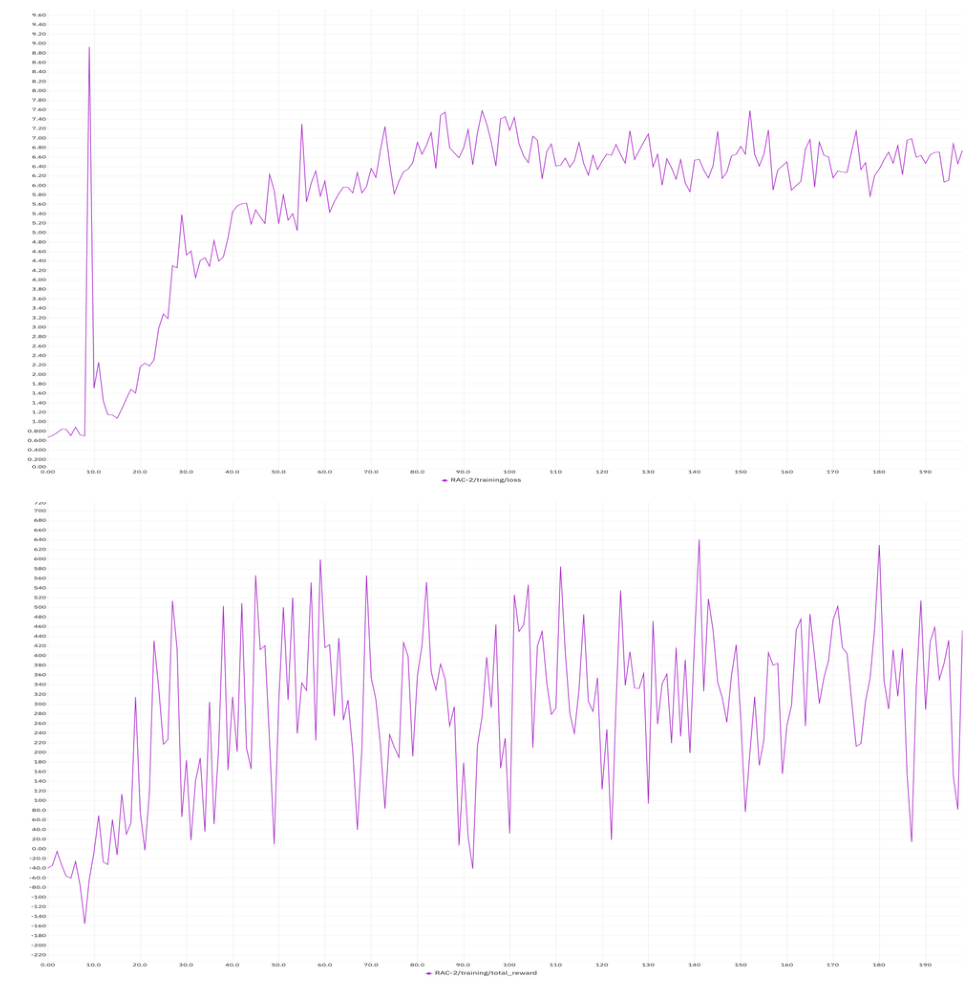

In [ ]:
from PIL import Image as PILImage
from IPython.display import display
import matplotlib.pyplot as plt


listOfImageNames = ['./images/training_loss_vanilla.png', './images/training_total_reward_vanilla.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]  # Adjust the size as needed

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
plt.tight_layout()  # Adjust layout

plt.show()

## Plot validation mean reward and validation std reward

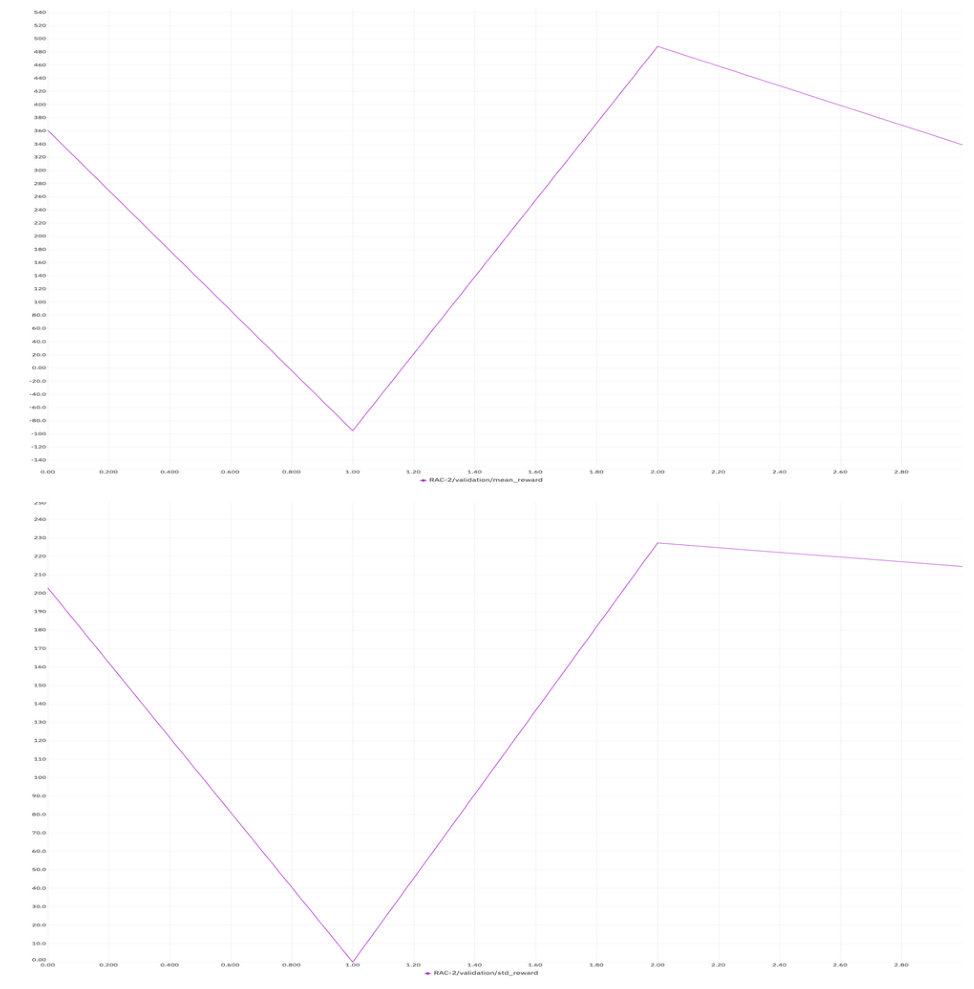

In [ ]:
listOfImageNames = ['./images/validation_mean_reward_v.png', './images/validation_std_reward_v.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout

plt.show()

Please include a plot of the training and validation rewards over the episodes in the report. An additional question to answer is does the loss matter in DQN? Why or why not?

We can also draw a animation of the car in one game, the code is provided below

The loss does not really matter in DQN. If the loss diverges, then it certainly implies our implentation or parameters are not right. But if the loss is merely increasing at a constant level, it does not matter too much as long as our reward is increasing. This loss is measuring the difference between our predicted Q value and the bootstrapped Q value. The bootstrapped Q value is a very rough estimation of the true Q value, which will induce variances. Moreover, as our Q value increases, we expect the loss to become larger. A better criterion is the relative error which is $$\frac{|Q - \gamma Q_{bootstrap}|}{|Q_{bootstrap}|}$$.

In [ ]:
eval_env = gym.make('CarRacing-v2', continuous=True, render_mode='rgb_array')
eval_env = EnvWrapper(eval_env)

total_rewards, frames = trainerDQN.play_episode(0,True,200)
anim = animate(frames)
HTML(anim.to_jshtml())

### Double DQN
In the original paper, where the algorithim is shown above, the estimated target Q value was computed using the current Q network's weights. However, this can lead to overestimation of the Q values. To mitigate this, we can use the target network to compute the target Q value. This is known as Double DQN.
#### Hard updating Target Network (5 points)
Original implementations for this involved hard updates, where the model weights were copied to the target network every C steps. This is known as hard updating. This was what was used in the Nature Paper by Mnih et al 2015 "Human-level control through deep reinforcement learning"

Please implement this by implementing the `_optimize_model` and `_update_model` classes in `HardUpdateDQN` in `DQN.py`.


In [ ]:
import DQN
import utils
import torch
from env_wrapper import EnvWrapper
import model
trainerHardUpdateDQN = DQN.HardUpdateDQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                update_freq = 100,
                lr = 0.00025,
                gamma = 0.95,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = True,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DoubleDQN_HardUpdates/","./runs/"))

trainerHardUpdateDQN.train(200,50,30,50,50)

saving to ./runs/DoubleDQN_HardUpdates/run3


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/zxzrandom/racing-car-dqn/e/RAC-5
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/zxzrandom/racing-car-dqn-h/e/RAC1-3


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'function'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered int

Episode: 1: Time: 12.573162078857422 Total Reward: -59.74358974359022 Avg_Loss: 0.8012086749076843
Episode: 2: Time: 10.703187942504883 Total Reward: -47.55474452554786 Avg_Loss: 0.6821182370185852
Episode: 3: Time: 10.601519107818604 Total Reward: -34.28571428571432 Avg_Loss: 0.7718913555145264
Episode: 4: Time: 11.456376791000366 Total Reward: -64.69696969697053 Avg_Loss: 0.6755063533782959
Episode: 5: Time: 11.172210454940796 Total Reward: -52.74647887324035 Avg_Loss: 0.668891429901123
Episode: 6: Time: 10.861525058746338 Total Reward: -56.83206106870289 Avg_Loss: 0.6417894959449768
Episode: 7: Time: 10.973984479904175 Total Reward: -40.312500000000156 Avg_Loss: 0.7342907786369324
Episode: 8: Time: 11.003405332565308 Total Reward: -40.652173913043725 Avg_Loss: 0.7017867565155029
Episode: 9: Time: 10.87828803062439 Total Reward: -45.75757575757609 Avg_Loss: 0.7362194061279297
Episode: 10: Time: 11.995910882949829 Total Reward: -39.44444444444463 Avg_Loss: 0.7161953449249268
Episode: 

In [ ]:
total_rewards, frames = trainerHardUpdateDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

## Double DQN (hard updating) training loss and training total reward

# The final test mean reward is **467** with a std **132**


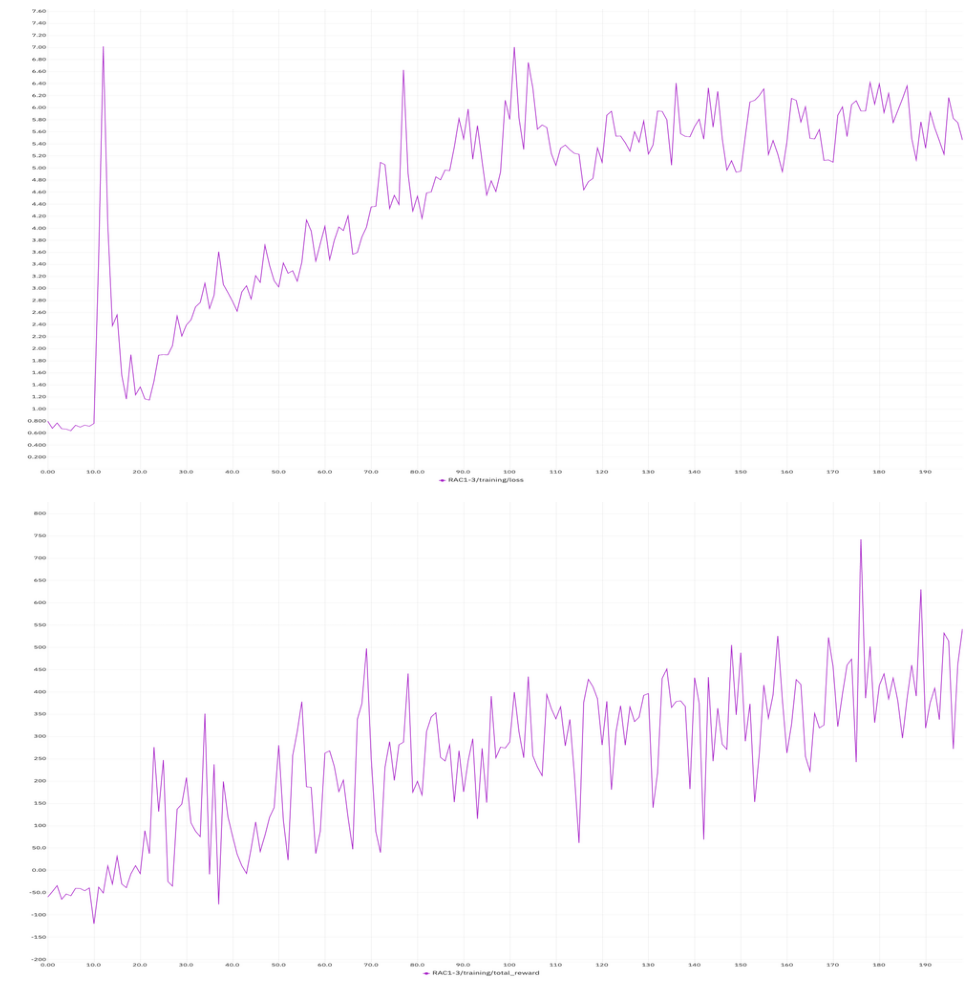

In [ ]:

listOfImageNames = ['./images/training_loss_h.png', './images/training_total_reward_h.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]  # Adjust the size as needed

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
plt.tight_layout()  # Adjust layout

plt.show()

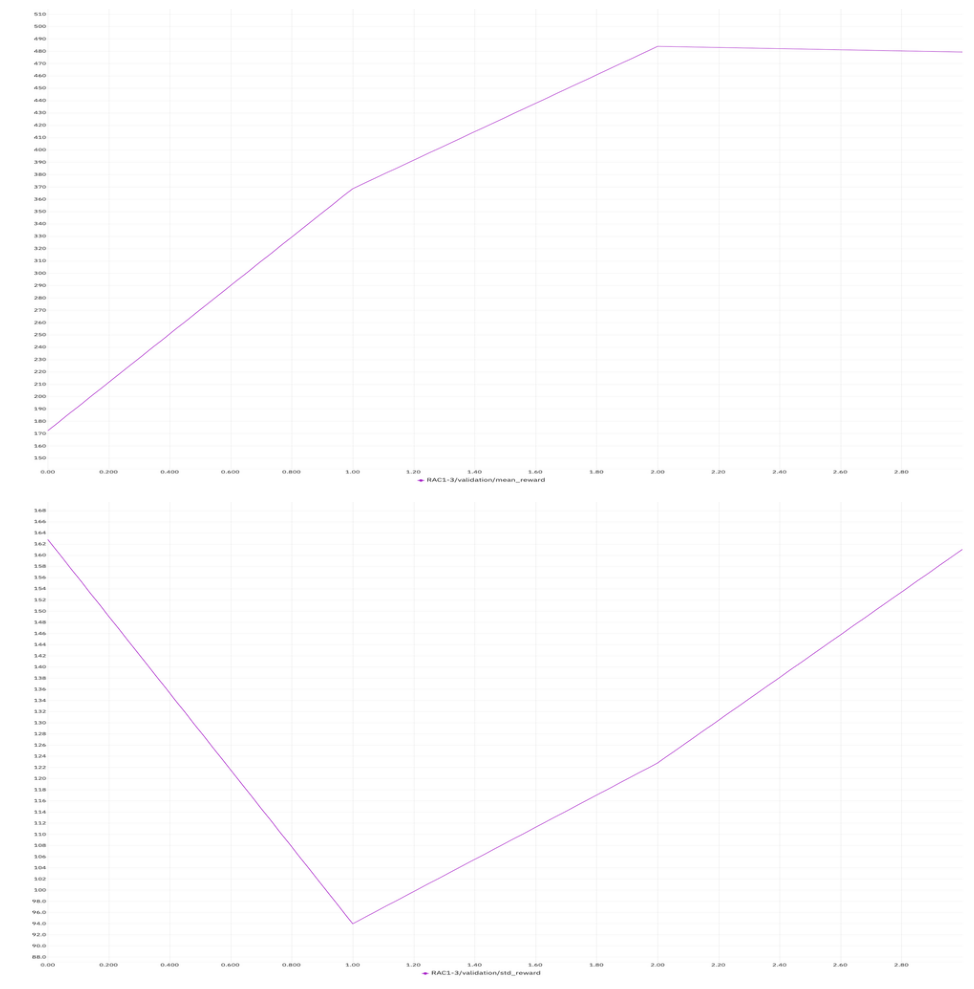

In [ ]:
listOfImageNames = ['./images/validation_mean_reward_h.png', './images/validation_std_reward_h.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout

plt.show()

#### Soft Updates (5 points)
A more recent improvement is to use soft updates, also known as Polyak averaging, where the target network is updated with a small fraction of the current model weights every step. In other words:
$$\theta_{target} = \tau \theta_{model} + (1-\tau) \theta_{target}$$
for some $\tau << 1$
Please implement this by implementing the `_update_model` class in `SoftUpdateDQN` in `DQN.py`.

In [ ]:
import DQN
import utils
import torch
from env_wrapper import EnvWrapper
import model
traineSoftUpdateDQN = DQN.SoftUpdateDQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                tau = 0.05,
                update_freq = 1,
                lr = 0.00025,
                gamma = 0.95,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = True,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DoubleDQN_SoftUpdates","./runs/"))

traineSoftUpdateDQN.train(200,50,30,50,50)

saving to ./runs/DoubleDQN_SoftUpdates/run3
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/zxzrandom/racing-car-dqn/e/RAC-9
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/zxzrandom/racing-car-dqn-h/e/RAC1-7
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/zxzrandom/racing-car-dqn-s/e/RAC2-4
Episode: 1: Time: 9.757834911346436 Total Reward: -28.085501858735995 Avg_Loss: 0.8909322023391724
Episode: 2: Time: 11.014243602752686 Total Reward: -39.76744186046566 Avg_Loss: 0.8173542618751526
Episode: 3: Time: 10.60896348953247 Total Reward: -75.39215686274518 Avg_Loss: 0.7364377379417419
Episode: 4: Time: 10.963176965713501 Total Reward: -68.33333333333383 Avg_Loss: 0.6800834536552429
Episode: 5: Time: 10.945744752883911 Total Reward: -53.90410958904163 Avg_Loss: 0.6791315674781799
Episode: 6: Time: 10.771764039993286 Total Reward: -69.54545454545499 Avg_Loss: 0.7228586673736572
Episode: 7: Tim

In [ ]:
total_rewards, frames = traineSoftUpdateDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

# Plot soft update training loss and training total reward ($\tau=0.01$)

# For $\tau=0.01$, the final test mean reward is **539** with a std **162**

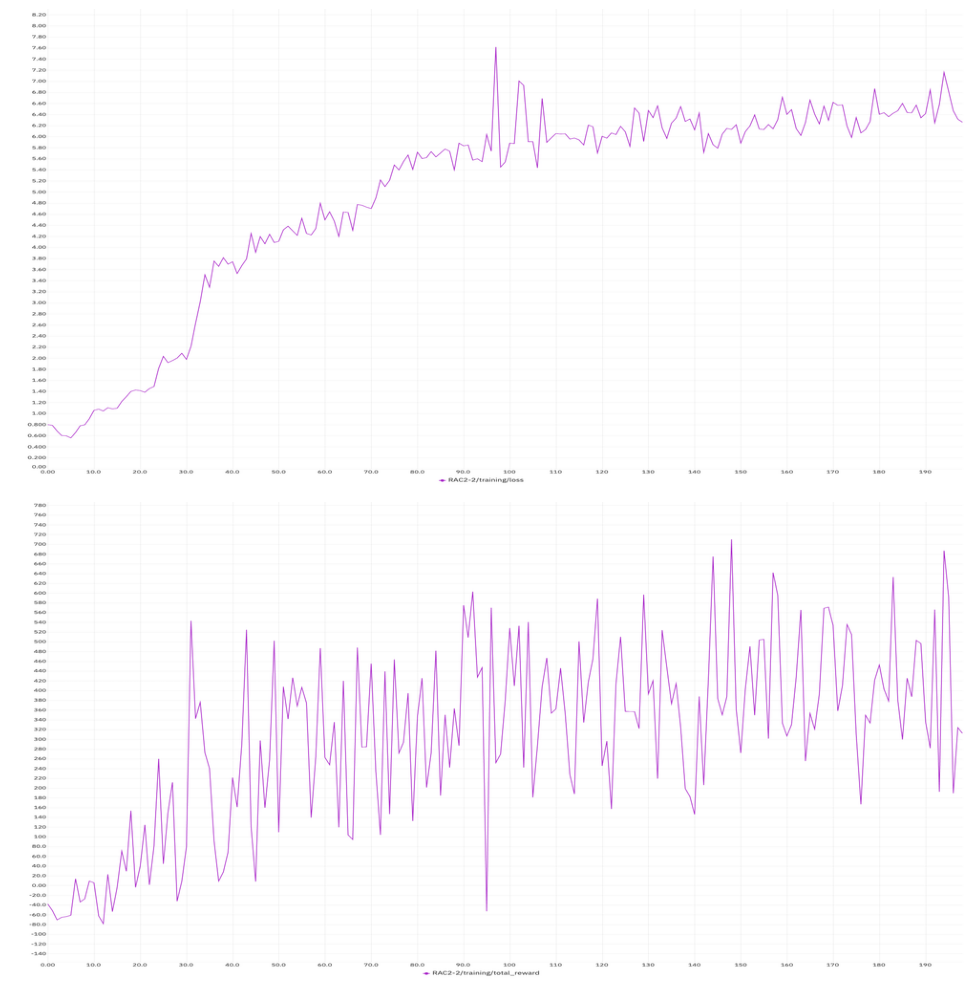

In [ ]:

listOfImageNames = ['./images/training_loss_s1.png', './images/training_total_reward_s1.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]  # Adjust the size as needed

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
plt.tight_layout()  # Adjust layout

plt.show()

# Plot soft update validation loss and validation total reward ( $\tau=0.01$ )

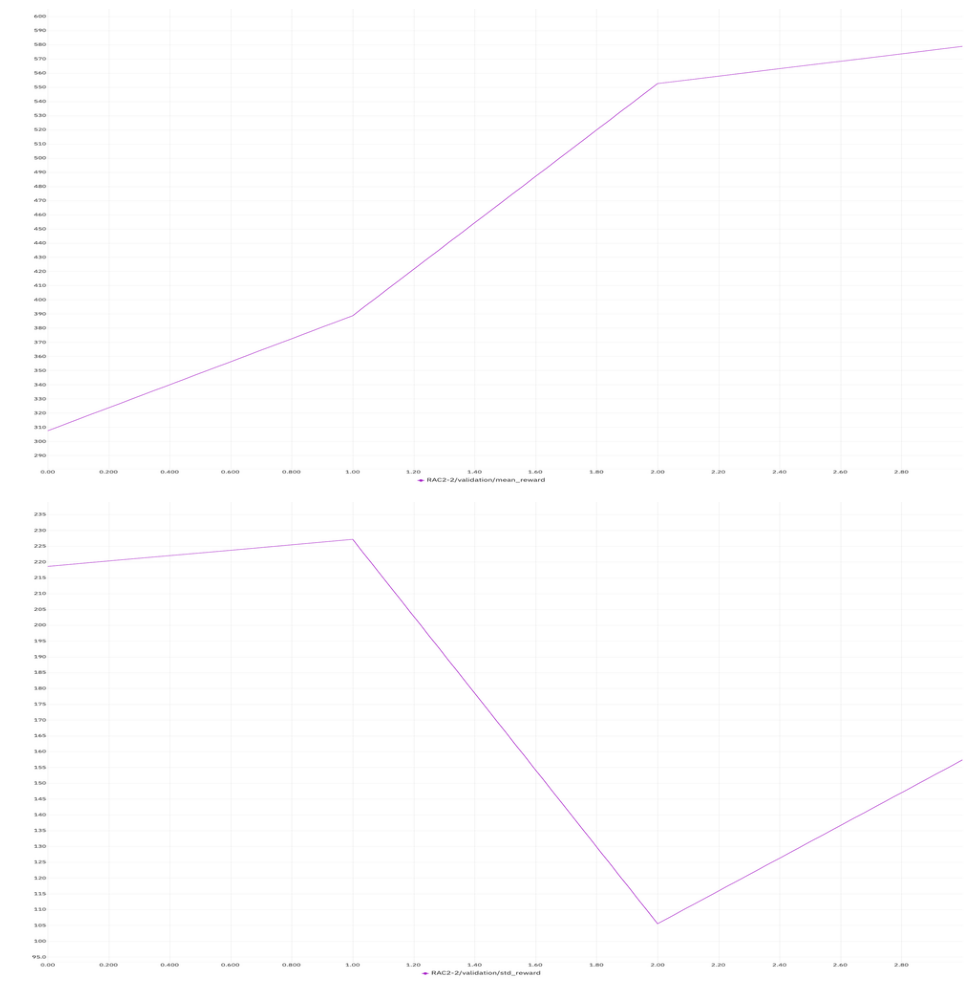

In [ ]:
listOfImageNames = ['./images/validation_mean_reward_s1.png', './images/validation_std_reward_s1.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout

plt.show()

# Plot soft update training loss and training total reward ($\tau=0.05$)

# For $\tau=0.05$, the final test mean reward is **468** with a std **119**

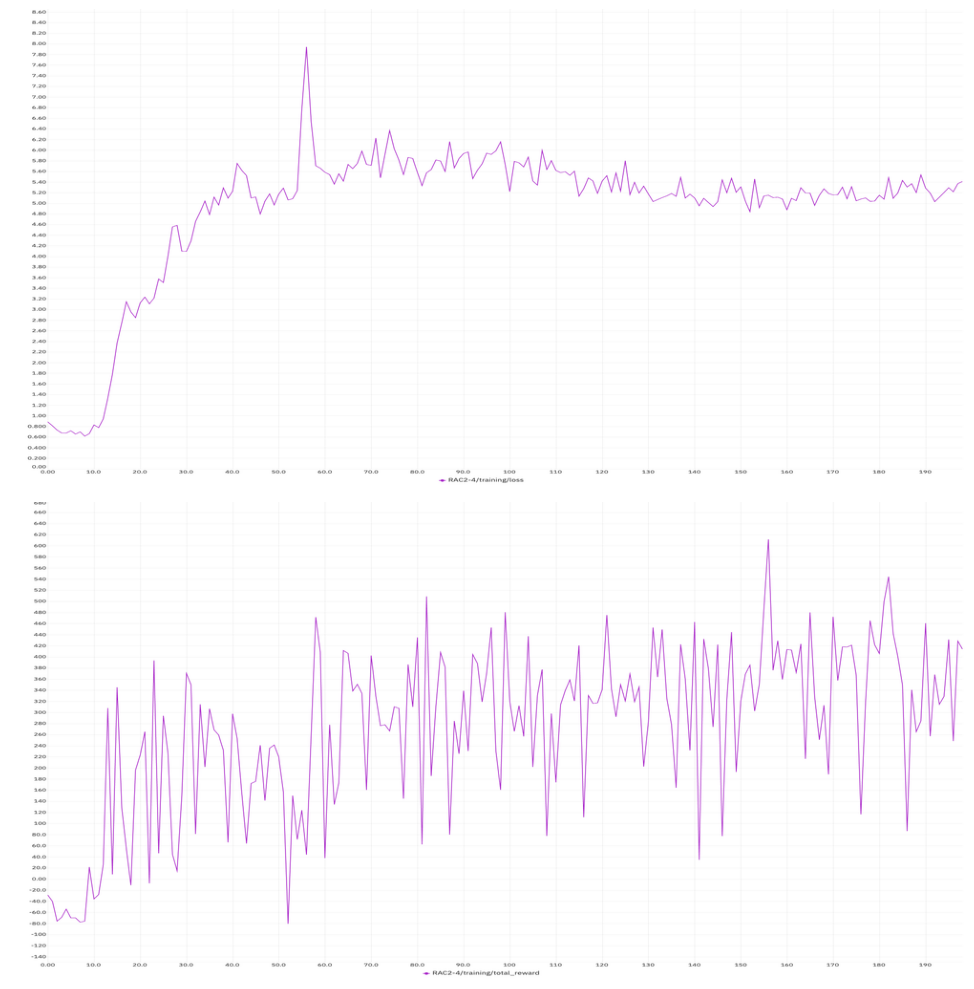

In [ ]:

listOfImageNames = ['./images/training_loss_s2.png', './images/training_total_reward_s2.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]  # Adjust the size as needed

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
plt.tight_layout()  # Adjust layout

plt.show()

# Plot soft update validation loss and validation total reward ( $\tau=0.05$ )

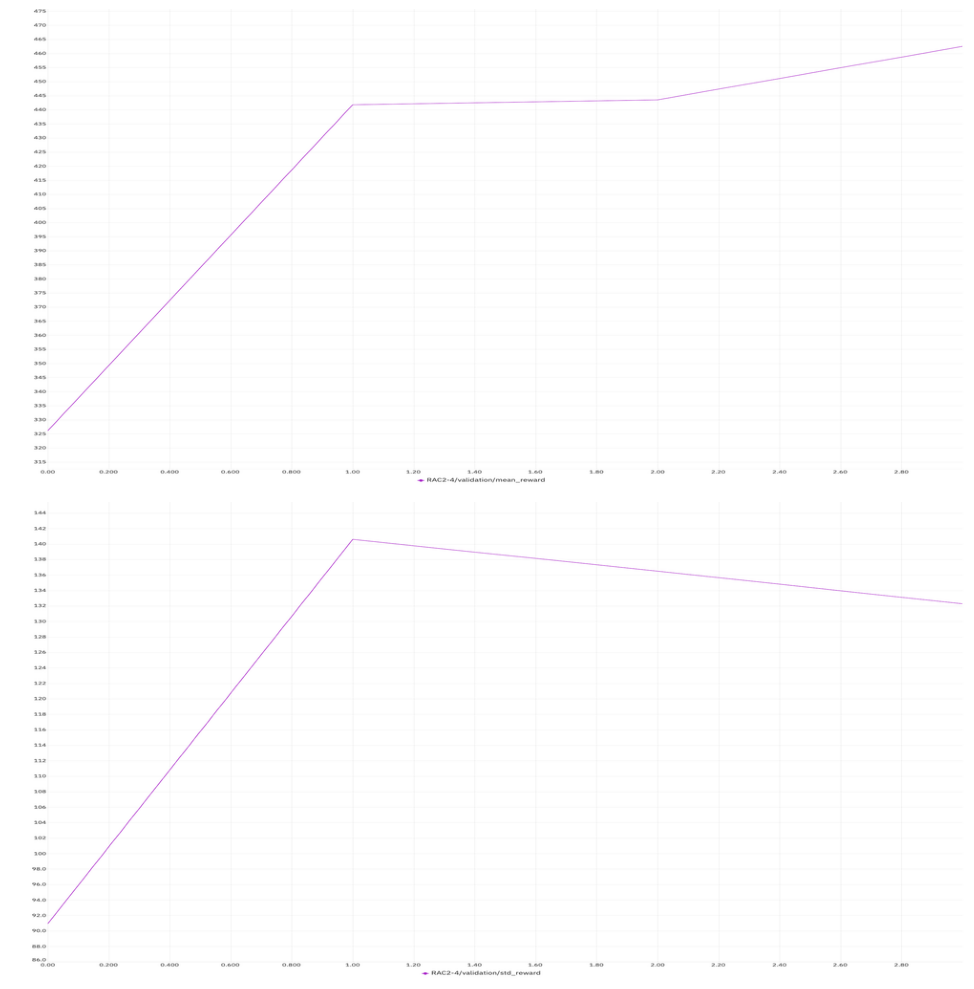

In [ ]:
listOfImageNames = ['./images/validation_mean_reward_s2.png', './images/validation_std_reward_s2.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1000, 500), PILImage.LANCZOS) for imageName in listOfImageNames]

# Display images side by side
fig, axes = plt.subplots(len(images),1, figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout

plt.show()

#### Questions:
- Which method performed better? (5 points)
- If we modify the $\tau$ for soft updates or the $C$ for the hard updates, how does this affect the performance of the model, come up with a intuition for this, then experimentally verify this.
 (5 points)




*   In terms of test mean reward, soft update with $\tau = 0.01$ works the best with a mean of 539, followed by soft update with $\tau=0.05$ which gives a mean of 468, followed by hard update with update_freq = 100 which gives a mean of 467, followed by vanilla DQN with a mean of 417.
*   I modified $\tau$ from 0.01 to 0.05. If $\tau$ is too big (approach 1), then the model will be similar to vanilla DQN, whereas if $\tau$ is too small (approach 0), then the target network will not learn anything meaningful. In either case, the test reward will be small. So there is a sweetspot for $\tau \in (0,1)$. It seems that based on my experiment, $\tau=0.05$ is a bit large (but still better compared to vanilla DQN). So the default $\tau=0.01$ is a good choice.

